In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

import mutagenesis_functions as mf
import time as time

In [2]:
# load hairpin data
data_path = '../../../data_toyhairpin/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.expand_dims(np.array(dataset['train_seq']).transpose([0, 2, 1]), axis=2)
    X_train_struct = np.expand_dims(np.array(dataset['train_structures']).transpose([0, 2, 1]), axis=2)
    Y_train = np.expand_dims(np.array(dataset['train_targets']), axis=1)
    X_test_seq = np.expand_dims(np.array(dataset['test_seq']).transpose([0, 2, 1]), axis=2)
    X_test_struct = np.expand_dims(np.array(dataset['test_structures']).transpose([0, 2, 1]), axis=2)
    Y_test = np.expand_dims(np.array(dataset['test_targets']), axis=1)

num_data, seq_length, _, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

# put in a dictionary for deepomics
train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}




In [3]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    
    layer4 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                    # concat, embedding, variational_normal, variational_softmax, + more
          'num_units': 196,
          'norm': 'batch',          # if removed, automatically adds bias instead
          'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
          'dropout': 0.5,           # if removed, default is no dropout
             }

    
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../../../results/toyhairpin'
param_path = os.path.join(save_path, 'resbindx')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: dense_0
(?, 196)
layer17: dense_0_batch
(?, 196)
layer18: dense_0_active
(?, 196)
layer19: dense_0_dropout
(?, 196)
layer20: dens

In [6]:
# initialize session
sess.close()
sess = utils.initialize_session()

In [7]:
#Train the model

data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=20, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

Epoch 1 out of 100 
[==============================] 100.0% -- elapsed time=14.31s -- loss=0.29182 -- acc=86.95990%  
 
  valid loss:		0.10080
  valid accuracy:	0.96596+/-0.00000
  valid auc-roc:	0.99501+/-0.00000
  valid auc-pr:		0.98626+/-0.00000
  lower cross-validation found
  saving model to:  ../results/toyhairpin/resbindx_best.ckpt
Epoch 2 out of 100 
[==============================] 100.0% -- elapsed time=13.68s -- loss=0.17016 -- acc=93.64271%  
 
  valid loss:		0.11597
  valid accuracy:	0.95642+/-0.00000
  valid auc-roc:	0.99521+/-0.00000
  valid auc-pr:		0.98575+/-0.00000
Epoch 3 out of 100 
[==============================] 100.0% -- elapsed time=13.64s -- loss=0.15327 -- acc=94.49427%  
 
  valid loss:		0.09547
  valid accuracy:	0.96590+/-0.00000
  valid auc-roc:	0.99669+/-0.00000
  valid auc-pr:		0.98963+/-0.00000
  lower cross-validation found
  saving model to:  ../results/toyhairpin/resbindx_best.ckpt
Epoch 4 out of 100 
[==============================] 100.0% -- elapse

In [7]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../../../results/toyhairpin/resbindx_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/toyhairpin/resbindx_best.ckpt
  test  loss:		0.04233
  test  accuracy:	0.99338+/-0.00000
  test  auc-roc:	0.99974+/-0.00000
  test  auc-pr:		0.99903+/-0.00000


## First order mutagenesis saliency

In [8]:
# sort activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


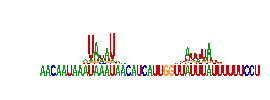

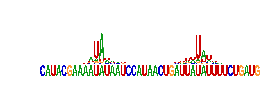

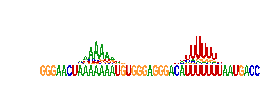

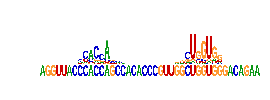

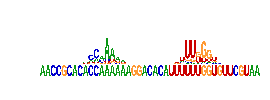

In [9]:
numplots=5

for ii in range(numplots): 

    X = np.expand_dims(test['inputs'][plot_index[ii]], axis=0)
    
    mf.fom_saliency(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess, figsize=(15,1.5))
    

## Second Order Mutagenesis 

In [12]:
savepath = 'Arrays/toyhairpin_resbindx_sumoutputs1k.npy'

num_summary = 1000
X = test['inputs'][plot_index[:num_summary]]

sum_mut2 = mf.som_average(X, savepath, nntrainer, sess, progress='on')

0
Epoch duration =0.42s
Cumulative duration =0.42s

1
Epoch duration =0.41s
Cumulative duration =0.83s

2
Epoch duration =0.41s
Cumulative duration =1.23s

3
Epoch duration =0.41s
Cumulative duration =1.65s

4
Epoch duration =0.41s
Cumulative duration =2.06s

5
Epoch duration =0.41s
Cumulative duration =2.47s

6
Epoch duration =0.42s
Cumulative duration =2.89s

7
Epoch duration =0.41s
Cumulative duration =3.3s

8
Epoch duration =0.41s
Cumulative duration =3.71s

9
Epoch duration =0.42s
Cumulative duration =4.14s

10
Epoch duration =0.41s
Cumulative duration =4.54s

11
Epoch duration =0.41s
Cumulative duration =4.95s

12
Epoch duration =0.52s
Cumulative duration =5.47s

13
Epoch duration =0.42s
Cumulative duration =5.89s

14
Epoch duration =0.41s
Cumulative duration =6.3s

15
Epoch duration =0.42s
Cumulative duration =6.72s

16
Epoch duration =0.41s
Cumulative duration =7.13s

17
Epoch duration =0.41s
Cumulative duration =7.54s

18
Epoch duration =0.41s
Cumulative duration =7.95s

19
Ep

In [16]:
#Load the saved data
savepath = 'Arrays/toyhairpin_resbindx_sumoutputs1k.npy'
sum_mut2 = np.load(savepath)

#average the values
num_summary = 1000
mean_mut2 = sum_mut2/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4
meanhol_mut2 = mean_mut2.reshape(X.shape[1],X.shape[1],4,4)

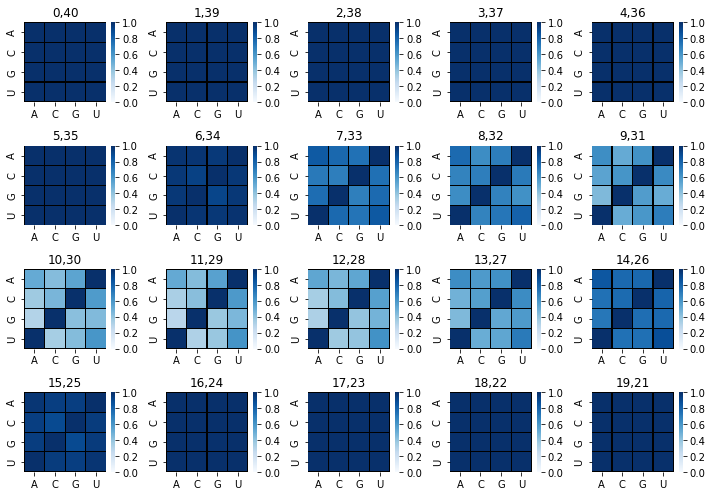

In [17]:
mf.symlinear_holplot(meanhol_mut2, figplot=(4,5), alphabet='rna')

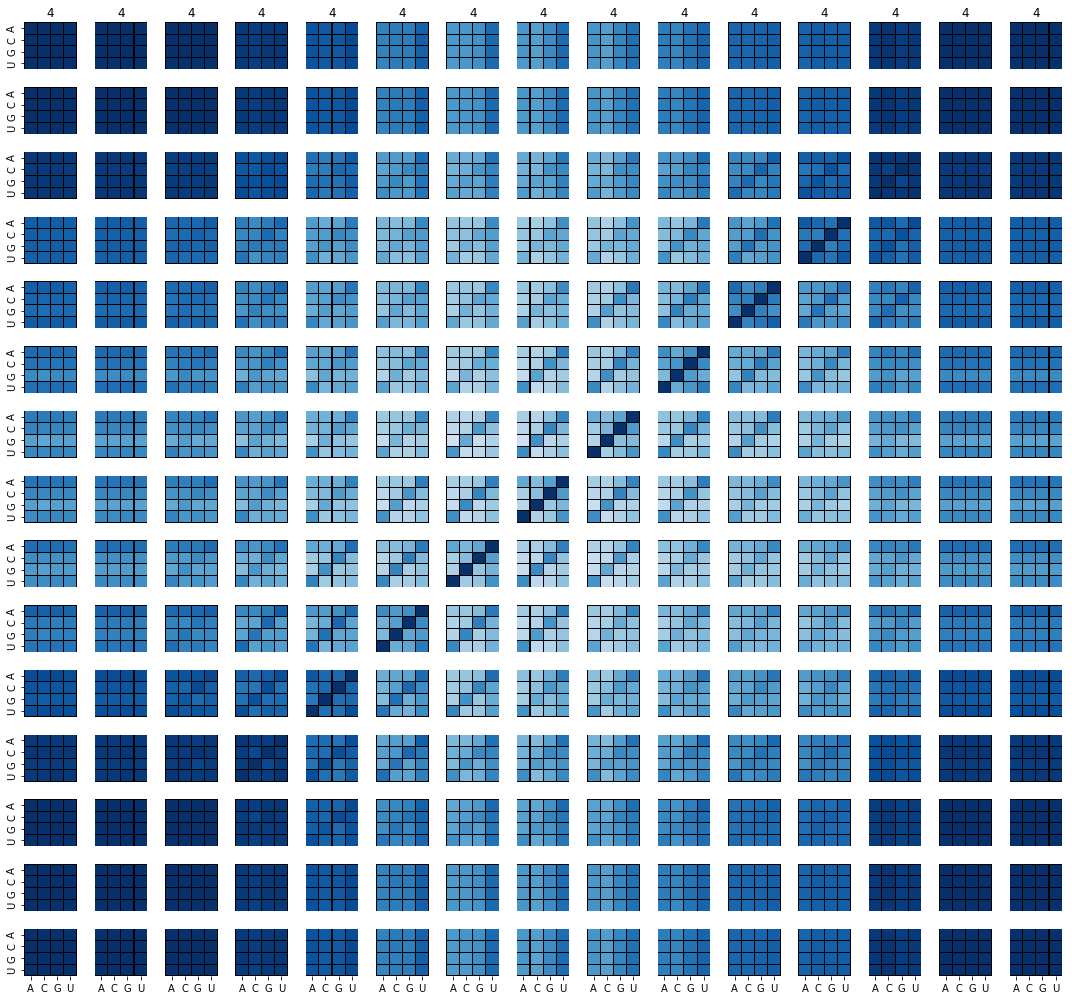

In [18]:
mf.square_holplot(meanhol_mut2, num=15, alphabet='rna', title=True)

## Look at Hidden Layers


### First layer filters

In [45]:
subtest = {'inputs': test['inputs'][:10000],
              'targets': test['targets'][:10000]}

V = nntrainer.get_activations(sess, subtest, layer='conv1d_0_active')
V = np.mean(V, axis=0)
V = np.max(V, axis=0)
top_filters = np.argsort(np.squeeze(V))

In [46]:
top_filters

array([39, 75, 21, 74, 69, 80, 94, 46, 53, 55, 28,  0, 77, 36, 50, 57, 32,
        9, 83, 95,  2, 27, 33, 19, 86, 45, 89, 43, 67,  1, 14, 44, 37, 91,
       17, 72, 15, 82, 24, 35, 79, 12, 30, 71, 63, 41, 25, 31,  8, 90, 81,
       58, 92, 51, 66, 40, 61, 73, 60, 20, 29,  5, 47, 65, 11, 87, 56, 49,
       18, 26, 23, 42, 70, 52, 22, 16, 84, 78, 64, 34, 62, 10, 93,  6, 38,
        7, 68, 85, 76,  3, 88, 59, 48, 54,  4, 13])

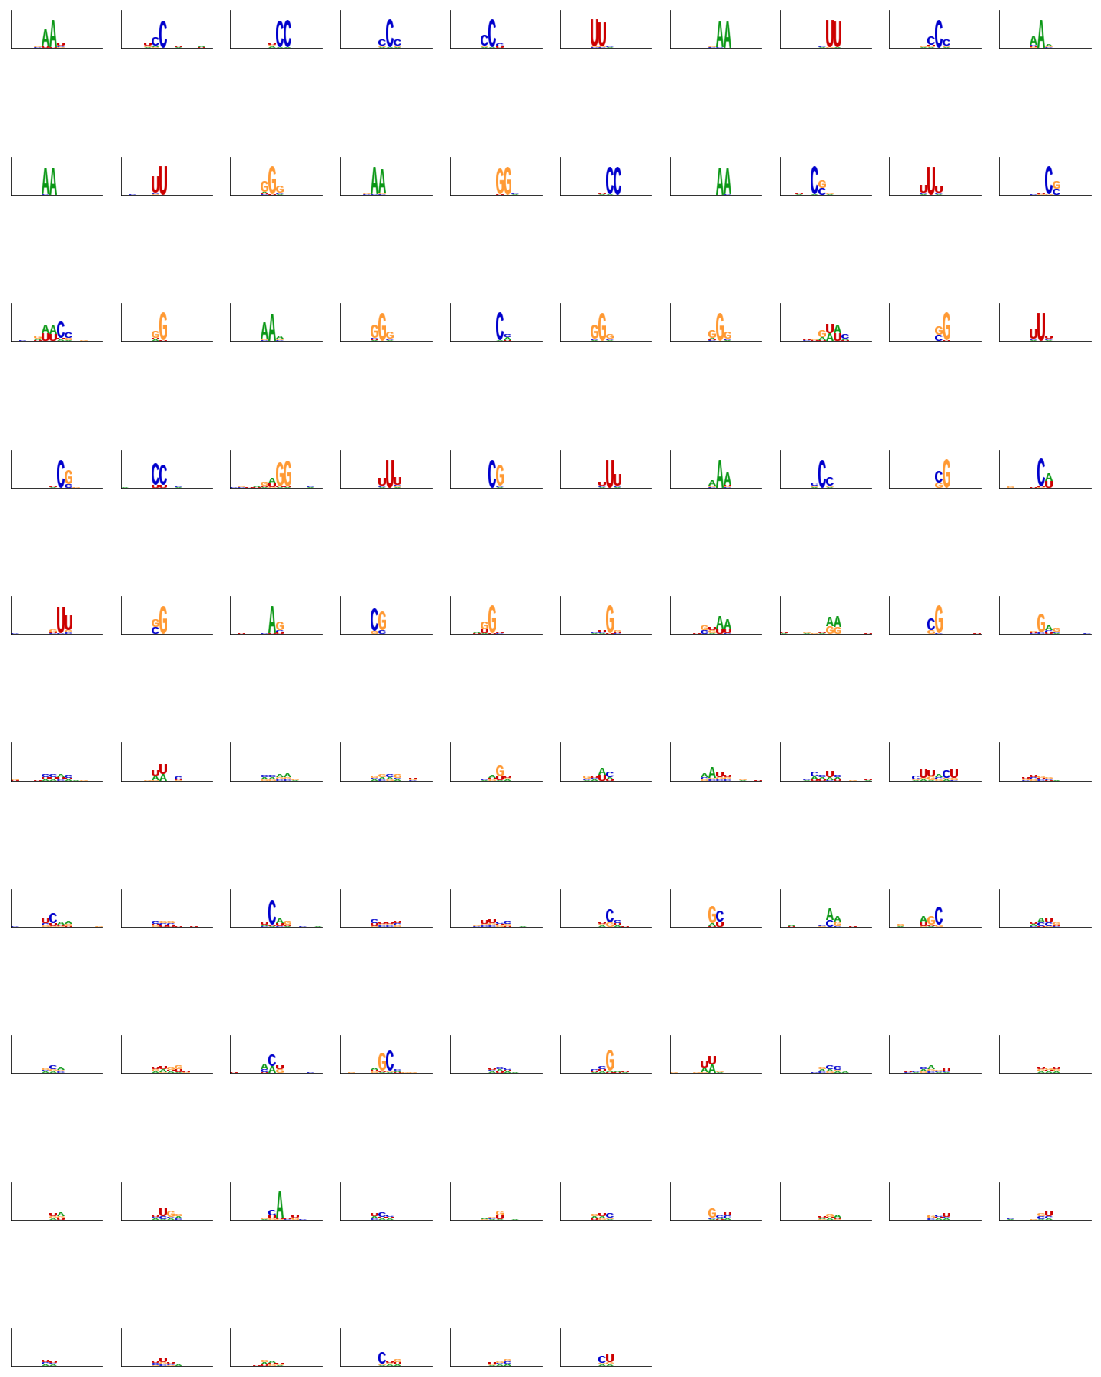

In [47]:
W = nnmodel.get_parameters(sess, layer='conv1d_0')[0]

num_plots = W.shape[3]
Wplot = W[:,:,:,top_filters[:num_plots]]

fig = visualize.plot_filter_logos(Wplot, figsize=(150,200), height=25,
                                 nt_width=10, norm=0, alphabet='rna')

### Post convolution features

In [74]:
conv1 = nntrainer.get_activations(sess, test, layer='conv1d_0_active')

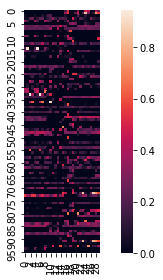

In [78]:
conv1_plot = np.squeeze(conv1[plot_index[0]]).T
sb.heatmap(conv1_plot, square=True)
plt.show()

### Dense layer neurons

In [51]:
N = nnmodel.get_parameters(sess, layer='dense_0')[0]

In [52]:
N.shape

(288, 196)

In [56]:
288/3

96.0